# Name: Tufan Kundu
# Reg no: 24MDT0184

## Outlier Detection

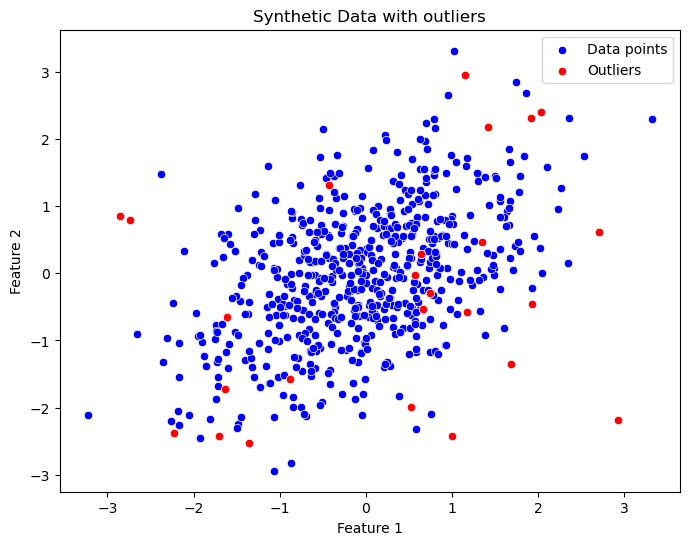

In [8]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#importing additional modules for specific outlier detection
from sklearn.neighbors import NearestNeighbors  # for KNN based outlier detection
from scipy.stats import chi2,zscore 

# set random seed for reproducibility
np.random.seed(42)

#generate synthetic 2D data:
# n_samples: number of normally distributed data points
# mean: the mean of the distribution (here a 2D point at [0,0])
# cov: covariance matrix defining the relationship between the features 

n_samples = 600
mean = [0,0]
cov = [[1,0.5],[0.5,1]]
#covariance matrix where off-diagonal elements represent correlation
data_normal = np.random.multivariate_normal(mean,cov,n_samples)

#inject some outliers:
# n_outliers: number of outliers to inject
# uniform distribution is used to generate outlier point over a broader range

n_outliers = 25
data_outliers = np.random.uniform(low = -3, high = 3, size = (n_outliers,2))

#combine the normal data and outliers
data_all = np.vstack([data_normal,data_outliers])

#creating pandas dataframe for easier manipulation
df = pd.DataFrame(data_all, columns = ['Feature1','Feature2'])

# plot the data to visualize the generated points and the injected outliers
plt.figure(figsize=(8,6))
sns.scatterplot(x='Feature1',y='Feature2',data=df,color = 'blue',label = 'Data points')
sns.scatterplot(x=data_outliers[:,0],y=data_outliers[:,1],color = 'red',label = 'Outliers')
plt.title("Synthetic Data with outliers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

- Here we have created a synthetic data with 600 samples with 25 outliers

## Z Score method

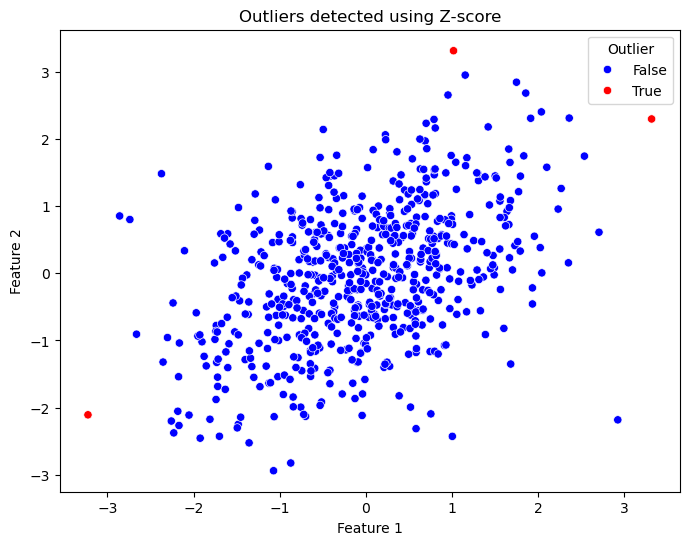

Z-score method detected outlier: 3


In [9]:
df_z = df.copy()

#calculate z-scores for each feature
df_z['Z_Feature1'] = zscore(df_z['Feature1'])
df_z['Z_Feature2'] = zscore(df_z['Feature2'])

# identifying outliers: Flag a data point as an outlier if the z-score is greater than 3
df_z['Outlier_Z'] = (df_z['Z_Feature1'].abs()>3) | (df_z['Z_Feature2'].abs()>3)

#plot the data points and highlight the outliers
plt.figure(figsize=(8,6))
sns.scatterplot(x = 'Feature1',y  = 'Feature2',data = df_z,hue = 'Outlier_Z', palette = {False:'blue',True:'red'})
plt.title("Outliers detected using Z-score")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title = 'Outlier')
plt.show()

# print the number of outliers detected using the Z-score method
print("Z-score method detected outlier:",df_z['Outlier_Z'].sum())

## IQR method

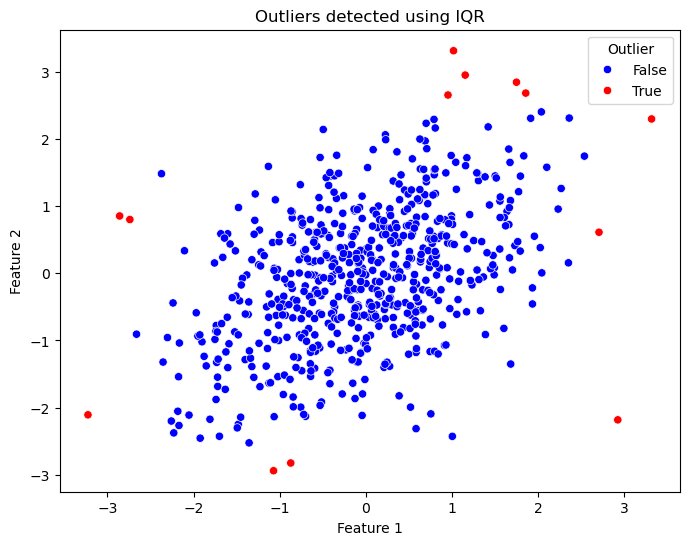

IQR method detected outliers: 13


In [10]:
# compute the first (Q1) and third (Q3) quartiles for each feature

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# calculate the interquartile range (IQR) for each feature
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# For 2D data, flag a point as an outlier if it is out of bounds in any feature
# The condition is applied for all columns, and if any column meets the condition, it is flagged
outlier_iqr = ((df<lower_bound) | (df>upper_bound)).any(axis=1)
df['Outlier_IQR'] = outlier_iqr

# plot the results to visualize outliers detected by the IQR method

plt.figure(figsize=(8,6))
sns.scatterplot(x='Feature1',y='Feature2',data=df,hue='Outlier_IQR',palette={False:'blue',True:'red'})
plt.title("Outliers detected using IQR")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Outlier')
plt.show()

print("IQR method detected outliers:",df['Outlier_IQR'].sum())

## KNN-based outlier detection

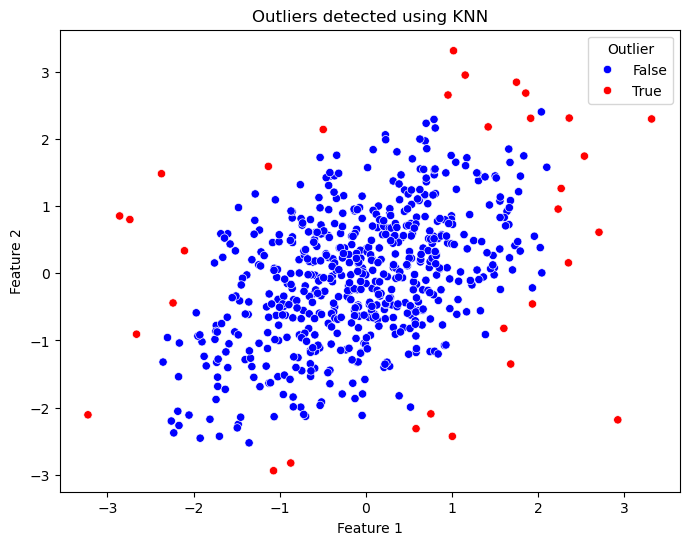

KNN method detected outliers: 32


In [11]:
# set the number of neighbours for the KNN method
k = 5

# Initialize and fit the NearestNeighbour model
# we use k+1 neighbour because the closest neighbour to a point is the point itself
nbrs = NearestNeighbors(n_neighbors=k+1)
nbrs.fit(df[['Feature1','Feature2']])

# calculate the distance to the k-th nearest neighbour for each data point
distances, indices = nbrs.kneighbors(df[['Feature1','Feature2']])

# Exclude the zero distance and compute the average distance to the k neighbours
avg_distance = distances[:,1:].mean(axis=1)

# Add a computed average KNN distance to the DataFrame
df['Avg_Distance'] = avg_distance

# set a threshold for outlier detection based on the 95th percentile of the average distances.
threshold_knn = np.percentile(avg_distance,95)
# flag points as outliers if the average distance is above the threshold
df['Outlier_KNN'] = df['Avg_Distance'] > threshold_knn

# plot the KNN outlier detection results
plt.figure(figsize=(8,6))   
sns.scatterplot(x='Feature1',y='Feature2',data=df,hue='Outlier_KNN',palette={False:'blue',True:'red'})
plt.title("Outliers detected using KNN")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Outlier')
plt.show()

print("KNN method detected outliers:",df['Outlier_KNN'].sum())



## Mahalanobis Distance

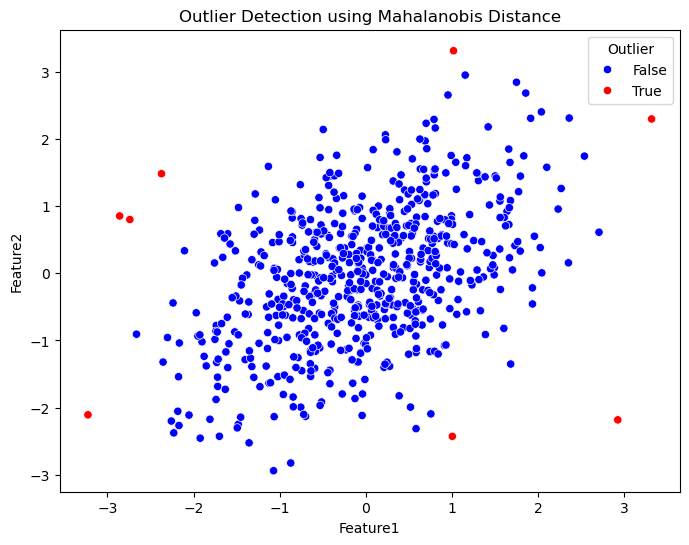

Mahalanobis method detected outliers: 8


In [12]:
def mahalanobis_distance(x=None, data=None, cov_inv=None):
    if cov_inv is None:
        cov = np.cov(data.T)
        cov_inv = np.linalg.inv(cov)
    x_minus_mu = x - np.mean(data, axis=0)
    left_term = np.dot(x_minus_mu, cov_inv)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal() if mahal.ndim > 0 else mahal

#Compute the covariance matrix for the features and then its inverse.
cov_matrix = np.cov(df[['Feature1', 'Feature2']].values.T)
cov_inv = np.linalg.inv(cov_matrix)

#Compute Mahalanobis distances for all observations.
m_dist = []

#Calculate the mean of the features to center the data.
mean_df = df[['Feature1', 'Feature2']].mean().values

#Iterate through each row (observation) in the DataFrame.
for i, row in df[['Feature1', 'Feature2']].iterrows():
    #Calculate the difference between the observation and the mean.
    diff = row.values - mean_df

    #Compute the Mahalanobis distance for the observation.
    md = np.sqrt(np.dot(np.dot(diff.T, cov_inv), diff))

    m_dist.append(md)

#Add the Mahalanobis distances to the DataFrame.
df['Mahalanobis_dist'] = m_dist

#Determine the threshold from the chi-square distribution.
#dof: degrees of freedom, which is equal to the number of features (2 in this case).
dof = 2
alpha = 0.99 #Confidence level for the threshold (99% quantile)

#Colculate the threshold value (square root because we compute Euclidean-like distances).
threshold_maha = np.sqrt(chi2.ppf(alpha, dof))

#Flag observations as outliers if their Mahalanobis distance exceeds the threshold.
df['Outlier_Mahalanobis'] = df['Mahalanobis_dist'] > threshold_maha

#Plot the results to visualize outliers detected by the Mahalanobis distance method.
plt.figure(figsize=(8, 6))

sns.scatterplot(x='Feature1', y='Feature2', data=df, hue='Outlier_Mahalanobis', palette={False: 'blue', True: 'red'})
plt.title('Outlier Detection using Mahalanobis Distance')

plt.xlabel('Feature1')
plt.ylabel('Feature2')

plt.legend(title='Outlier')
plt.show()

#Print the number of outliers detected using the Mahalanobis method.
print("Mahalanobis method detected outliers:", df['Outlier_Mahalanobis'].sum())